### Data Science using OSEMN

The first main step is to obtain all needed informations and import all needed libraries. Here I included the geojson data file from King County and extracted the needed data to help me visuzlize housing data. Next comes the handling of data which is either missing or just not clean. By going through the data and addressing the bits and peices ie NaN etc, helps me understand the data and hopfully can derive some statistics and visualizations. this follows a classifications and scaling of features. Finishing with the interpretation of what I can find.

1. Obtaining data
2. Scrubbing data
3. Exploring data
4. Modeling data 
5. Interpreting results


### Import all needed libraries 

In [1]:
import os
import math
import random

import pandas as pd
import numpy as np
import json

from scipy import stats
from scipy import linalg

import statsmodels.api as sm
import statsmodels.stats.stattools as sms
from statsmodels.formula.api import ols

from sklearn import metrics
from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import missingno as msno

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# set style
sns.set_style('whitegrid')
# overriding font size and line width
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# map visualization
import folium
from folium.plugins import HeatMap

# don't print matching warnings
import warnings
warnings.filterwarnings('ignore') 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("../input"))

['kc_house_data.csv']


In [2]:
# local functions which are in a seperate python file
#
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    """
    Perform a forward-backward feature selection based on p-value from statsmodels.api.OLS

    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features

    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """

    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)

        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]

        best_pval = new_pval.min()

        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True

            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()

        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        # null if pvalues is empty
        worst_pval = pvalues.max()

        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)

            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break

    return included


def display_heatmap(data):
    """
    Display a heatmap from a given dataset

    :param data: dataset
    :return: g (graph to display)
    """

    # Set the style of the visualization
    # sns.set(style = "white")
    sns.set_style("white")

    # Create a covariance matrix
    corr = data.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = None

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 10, sep=20, n=9, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    g = sns.heatmap(corr, cmap=cmap, mask=mask, square=True)

    return g


def display_jointplot(data, columns):
    """
    Display seaborn jointplot on given dataset and feature list

    :param data: dataset
    :param columns: feature list
    :return: g
    """

    sns.set_style('whitegrid')

    for column in columns:
        g = sns.jointplot(x=column, y="price", data=data, dropna=True,
                          kind='reg', joint_kws={'line_kws': {'color': 'red'}})

    return g


def display_plot(data, vars, target, plot_type='box'):
    """
    Generates a seaborn boxplot (default) or scatterplot

    :param data: dataset
    :param vars: feature list
    :param target: feature name
    :param plot_type: box (default), scatter, rel
    :return: g
    """

    # pick one dimension
    ncol = 3
    # make sure enough subplots
    nrow = math.floor((len(vars) + ncol - 1) / ncol)
    # create the axes
    fig, axarr = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, 20))

    # go over a linear list of data
    for i in range(len(vars)):
        # compute an appropriate index (1d or 2d)
        ix = np.unravel_index(i, axarr.shape)

        feature_name = vars[i]

        if plot_type == 'box':
            g = sns.boxplot(y=feature_name, x=target, data=data, width=0.8,
                            orient='h', showmeans=True, fliersize=3, ax=axarr[ix])

        # elif plot_type == 'scatter':
        else:
            g = sns.scatterplot(x=feature_name, y=target, data=data, ax=axarr[ix])

        # else:
        #     col_name = vars[i]
        #     g = sns.relplot(x=feature_name, y=target, hue=target, col=col_name,
        #                     size=target, sizes=(5, 500), col_wrap=3, data=data)

    return g


def map_feature_by_zipcode(zipcode_data, col):
    """
    Generates a folium map of Seattle
    :param zipcode_data: zipcode dataset
    :param col: feature to display
    :return: m
    """

    # read updated geo data
    king_geo = "cleaned_geodata.json"

    # Initialize Folium Map with Seattle latitude and longitude
    m = folium.Map(location=[47.35, -121.9], zoom_start=9,
                   detect_retina=True, control_scale=False)
    # tiles='stamentoner')

    # Create choropleth map
    m.choropleth(
        geo_data=king_geo,
        name='choropleth',
        data=zipcode_data,
        # col: feature of interest
        columns=['zipcode', col],
        key_on='feature.properties.ZIPCODE',
        fill_color='OrRd',
        fill_opacity=0.9,
        line_opacity=0.2,
        legend_name='house ' + col
    )

    folium.LayerControl().add_to(m)

    # Save map based on feature of interest
    m.save(col + '.html')

    return m


def measure_strength(data, feature_list, target):
    """
    Calculate a Pearson correlation coefficient and the p-value to test for non-correlation.

    :param data: dataset
    :param feature_list: feature list
    :param target: feature name
    :return:
    """

    print("Pearson correlation coefficient R and p-value \n\n")

    for k, v in enumerate(feature_list):
        r, p = stats.pearsonr(data[v], data[target])
        print("{0} <=> {1}\t\tR = {2} \t\t p = {3}".format(target, v, r, p))


def heatmap_features_by_loc(data, feature):
    """
    Generates a heatmap based on lat, long and a feature

    :param data: dataset
    :param feature: feature name
    :return:
    """
    max_value = data[feature].max()

    lat = np.array(data.lat, dtype=pd.Series)
    lon = np.array(data.long, dtype=pd.Series)
    mag = np.array(data[feature], dtype=pd.Series) / max_value

    d = np.dstack((lat, lon, mag))[0]
    heatmap_data = [i for i in d.tolist()]

    hmap = folium.Map(location=[47.55, -122.0], zoom_start=10, tiles='stamentoner')

    hm_wide = HeatMap(heatmap_data,
                      min_opacity=0.7,
                      max_val=max_value,
                      radius=1, blur=1,
                      max_zoom=1,
                      )

    hmap.add_child(hm_wide)

    return hmap


In [3]:
# We can import the above function from a seperate python file:
#
# import function_filename as f
#
# you can check out the the documentation for the rest of the autoreaload modes
# by apending a question mark to %autoreload, like this:
# %autoreload?
#
# %load_ext autoreload
# %autoreload 2

#### Description of what can be found in the dataset

+ **ida** notation for a house
+ **date** Date house was sold
+ **price** Price is prediction target
+ **bedrooms** Number of Bedrooms/House
+ **bathrooms** Number of bathrooms/bedrooms
+ **sqft_living** square footage of the home
+ **sqft_lot** square footage of the lot
+ **floors** Total floors (levels) in house
+ **waterfront** House which has a view to a waterfront
+ **view** Has been viewed
+ **condition** How good the condition is ( Overall )
+ **grade** overall grade given to the housing unit, based on King County grading system (see below)
+ **sqft_above** square footage of house apart from basement
+ **sqft_basement** square footage of the basement
+ **yr_built** Built Year
+ **yr_renovated** Year when house was renovated
+ **zipcode** zip
+ **lat** Latitude coordinate
+ **long** Longitude coordinate
+ **sqft_living15** Living room area in 2015 (implies-- some renovations) This might or might not have affected the lot size area
+ **sqft_lot15** lotSize area in 2015 (implies-- some renovations)

http://www5.kingcounty.gov/sdc/FGDCDocs/resbldg_extr_faq.htm
##### BLDGGRADE
Buildling grade (Source: King County Assessments)
+ Value - Definition
+ 0     - Unknown
+ 1     - Cabin
+ 2     - Substandard
+ 3     - Poor
+ 4     - Low
+ 5     - Fair
+ 6     - Low Average
+ 7     - Average
+ 8     - Good
+ 9     - Better
+ 10    - Very Good
+ 11    - Excellent
+ 12    - Luxury
+ 13    - Mansion
+ 20    - Exceptional Properties


# Questions:


1. Is location of a house by zipcode/neighborhood an indicator for the house price? 
2. Do have zipcodes (neighborhoods) with the higher housing density an effect on selling price?
3. Does grade, condition and renovation of a house reflect in the price?

## Obtaining Data

In [4]:
# read data and read date correctly
#
dataset = pd.read_csv("../input/kc_house_data.csv", parse_dates = ['date'])

### Collecting basic informations about the data set

In [5]:
dataset.shape

(21613, 21)

In [6]:
dataset.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

___

# Scrubbing Data


## Cleaning Data

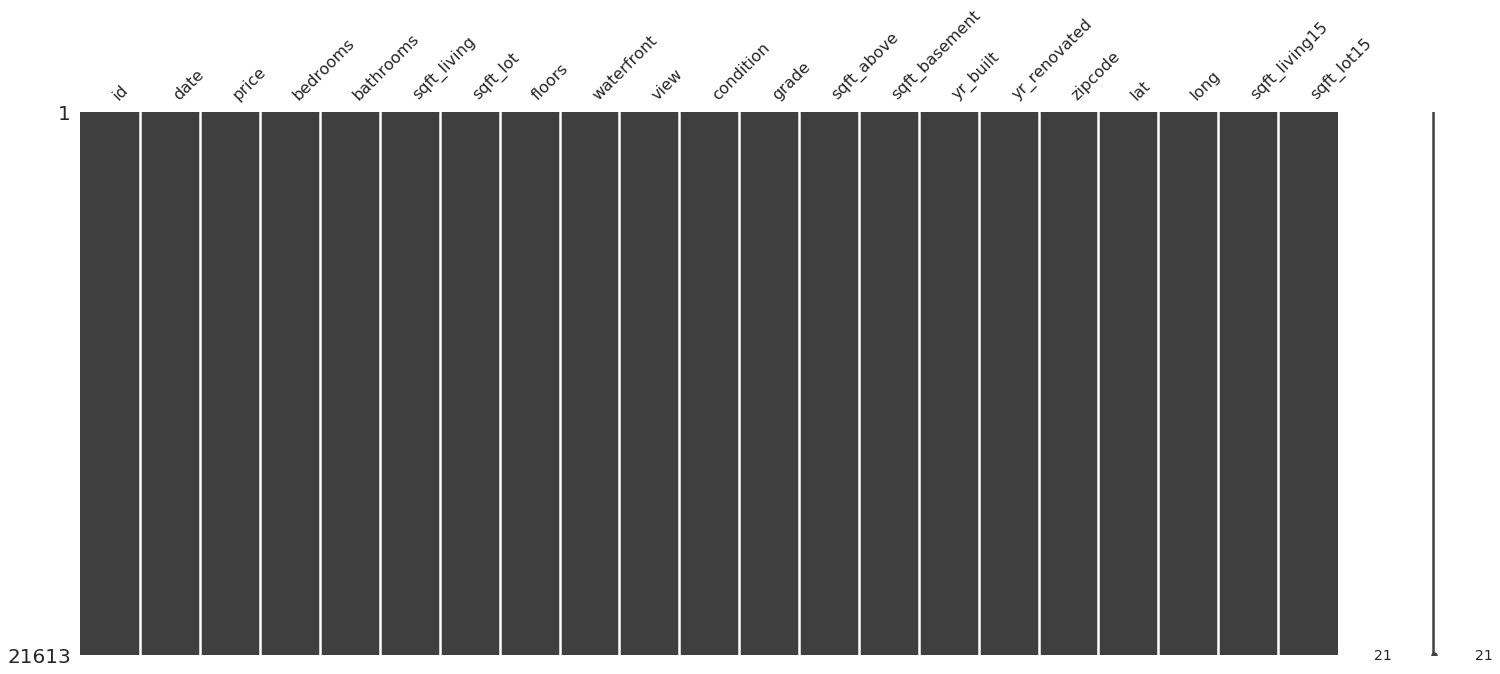

In [7]:
# Display all missing data
#
msno.matrix(dataset);

In [8]:
# Handling Null values for view
#
dataset.view.fillna(0, inplace=True)

In [9]:
# Handling yr_renovated
# - create new column 'is_renovated' and 'yr_since_renovation'
# - if sqft_living15 > sqft_living set renovated
# - drop yr_renovated
#
import datetime
cur_year = datetime.datetime.now().year

def calc_years(row):
    return cur_year - row['yr_renovated'] if row['yr_renovated'] > 0 else 0

def set_renovated(row):
    return 1 if row['yr_since_renovation'] > 0 or row['sqft_living'] != row['sqft_living15'] else 0

# Set yr_renovated to int
dataset.yr_renovated.fillna(0, inplace = True)
# now I can convert yr_renovated to int
dataset.yr_renovated = dataset.yr_renovated.astype('int64')

dataset['yr_since_renovation'] = dataset.apply(calc_years, axis = 1)

# Create category 'is_renovated'
dataset['is_renovated'] = dataset.apply(set_renovated, axis=1)
# Binning
bins = [0., 1950., 1980., 1990., 2000., 2015.]
names = ['never', 'before 1980', '1980-1989', '1990-1999', '2000-2015']
dataset['yr_renov_bins'] = pd.cut(dataset['yr_renovated'], bins, labels=names, right=False)
dataset.yr_renov_bins.fillna('never', inplace=True)

dataset.drop(columns=['yr_renovated'], inplace=True)

In [10]:
print(cur_year)

2019


In [11]:
dataset.yr_built.shape

(21613,)

In [12]:
dataset.yr_built.value_counts()

2014    559
2006    454
2005    450
2004    433
2003    422
2007    417
1977    417
1978    387
1968    381
2008    367
1967    350
1979    343
1959    334
1990    320
1962    312
2001    305
1954    305
1987    294
1989    290
1969    280
1955    271
1988    270
1999    265
1947    263
1963    256
1976    253
1966    250
1950    250
1994    249
1960    248
       ... 
1909     94
1906     92
1930     90
1919     88
1900     87
1908     86
1923     84
1912     79
1916     79
1921     76
1905     74
1911     73
1937     68
1907     65
1915     64
1931     61
1913     59
1917     56
1914     54
1938     52
1903     46
1904     45
1936     40
1932     38
2015     38
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

In [13]:
# While are at it, lets convert yr_built to house_age and drop yr_built
#
dataset['house_age'] = cur_year - dataset.yr_built
# dataset.drop(columns=['yr_built'], inplace=True)

In [14]:
dataset.house_age.value_counts()

5      559
13     454
14     450
15     433
16     422
42     417
12     417
41     387
51     381
11     367
52     350
40     343
60     334
29     320
57     312
65     305
18     305
32     294
30     290
50     280
64     271
31     270
20     265
72     263
56     256
43     253
53     250
69     250
25     249
59     248
      ... 
110     94
113     92
89      90
100     88
119     87
111     86
96      84
107     79
103     79
98      76
114     74
108     73
82      68
112     65
104     64
88      61
106     59
102     56
105     54
81      52
116     46
115     45
83      40
4       38
87      38
86      30
118     29
117     27
84      24
85      21
Name: house_age, Length: 116, dtype: int64

In [15]:
# To answer this question, it's best to build a new variable (feature engineering) ...
dataset['yr_built_cat'] = dataset['house_age'].apply(lambda x: ('old' if x >= 50 else 'middle-aged') if x >= 15 else 'modern')

# ... and turn it into a category
dataset['yr_built_cat'] = pd.Categorical(dataset['yr_built_cat'], categories = ['old', 'middle-aged', 'modern'])
dataset.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renovation,is_renovated,yr_renov_bins,house_age,yr_built_cat
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,0,1,never,64,old
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,28,1,1990-1999,68,old


In [16]:
dataset.yr_built_cat.value_counts()

old            10049
middle-aged     8405
modern          3159
Name: yr_built_cat, dtype: int64

In [17]:
# What is the percential of NaN in waterfront?
#
print(dataset.waterfront.isnull().sum() / dataset.shape[0])

0.0


In [18]:
# Because the percential is about 10% we set the NaN values to zero
#
dataset.waterfront.fillna(0, inplace=True)

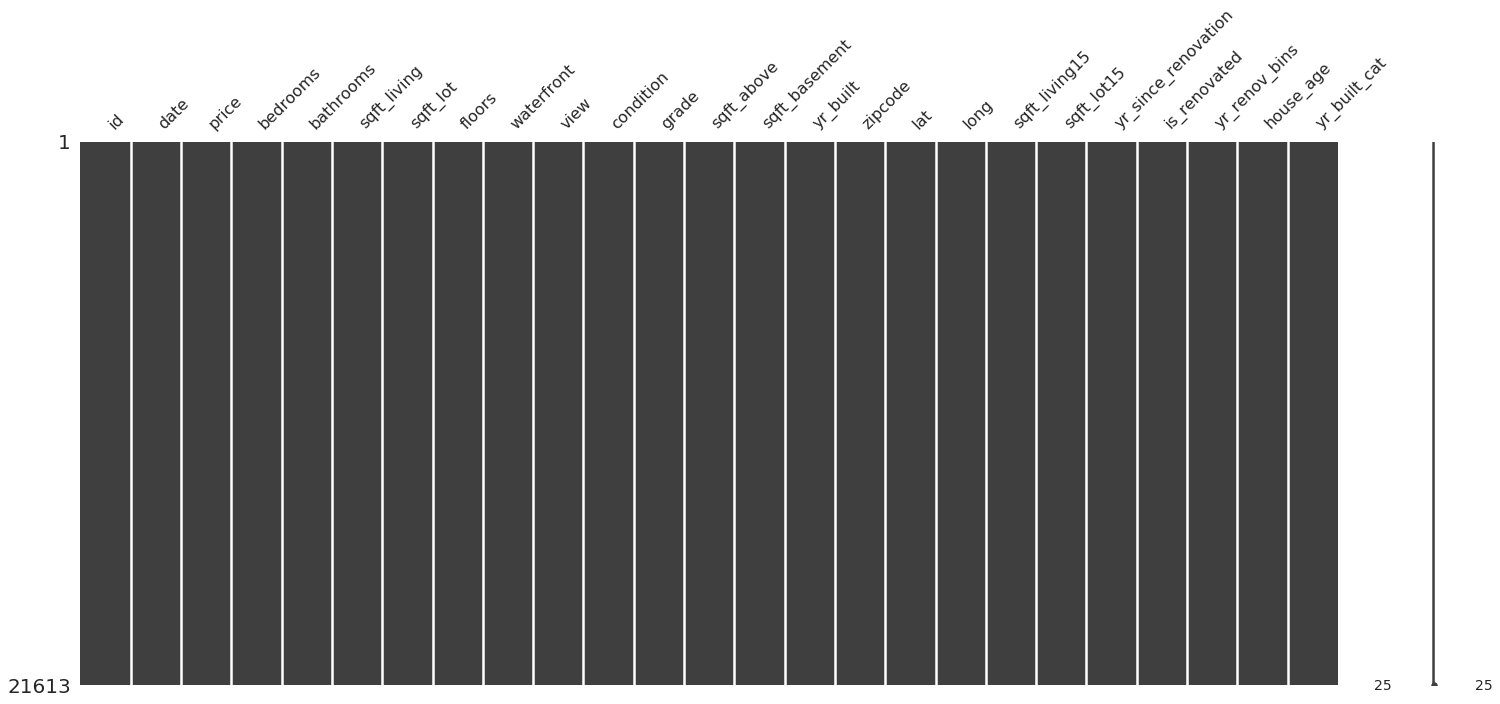

In [19]:
msno.matrix(dataset);

In [20]:
dataset.shape

(21613, 25)

### Cleaning basement feature

In [21]:
# Handling sqft_basement
#
def calc_basement(row):
    """
    Calculate basement sqft based on difference sqft_living and sqft_above
    Deals at the same time with the '?' string
    
    :param row: feature (column)
    :return: value (sqft)
    """
    return row['sqft_living'] - row['sqft_above'] if row['sqft_above'] < row['sqft_living']  else 0

dataset.sqft_basement = dataset.apply(calc_basement, axis = 1)

In [22]:
# sort dataset by date and reset index (Do I have a good reason for it? No.)
#
dataset = dataset.sort_values(by = ['date'])
dataset = dataset.reset_index(drop=True)

### Get the big picture

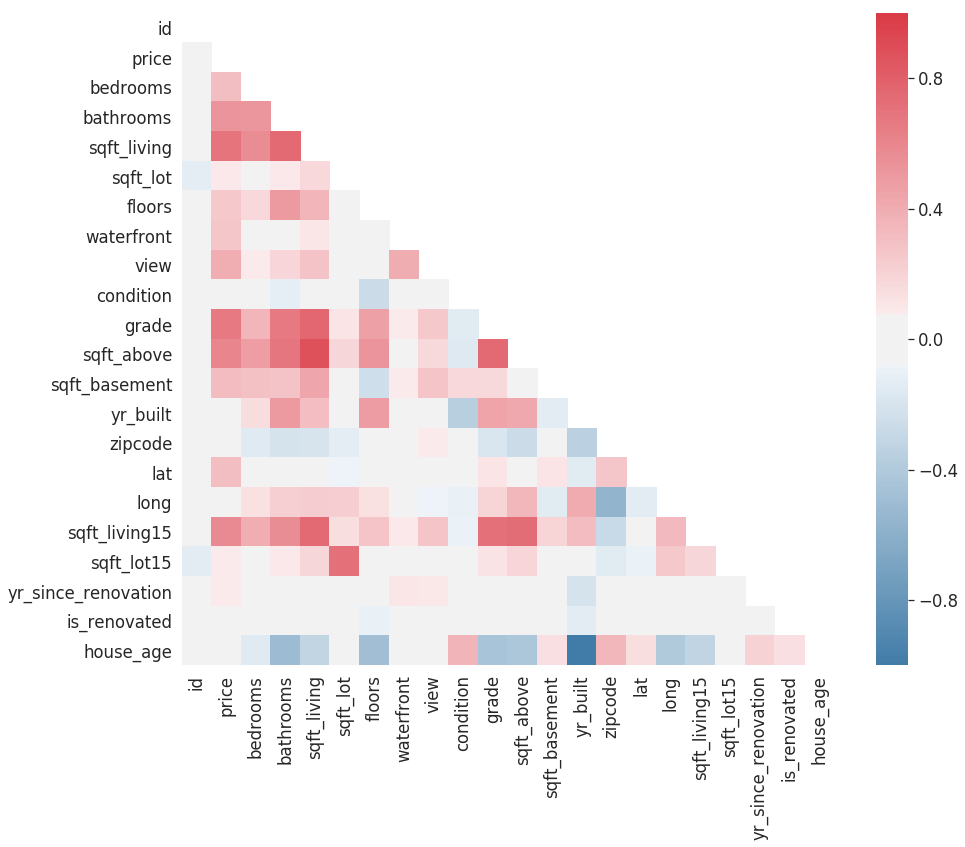

In [23]:
display_heatmap(dataset);

Initial observation (based on the darker colours/higher and lower values):
    * In general there are very few strong correlations (around +/-0.7 and beyond)
    * price correlates to sqft_living/15 and grade
    * grade correlates with sqft_above
    * house_age correlates with bathrooms, floors, grade, sqft_above
    * we can consolidate sqft_living, sqft_living15 and sqft_above

___

### Get a gerneral overview via scatter plot

In [24]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renovation,is_renovated,yr_renov_bins,house_age,yr_built_cat
0,5561000190,2014-05-02,437500.0,3,2.25,1970,35100,2.0,0,0,4,9,1970,0,1977,98027,47.4635,-121.991,2340,35100,0,1,never,42,middle-aged
1,472000620,2014-05-02,790000.0,3,2.50,2600,4750,1.0,0,0,4,9,1700,900,1951,98117,47.6833,-122.400,2380,4750,0,1,never,68,old
2,1024069009,2014-05-02,675000.0,5,2.50,2820,67518,2.0,0,0,3,8,2820,0,1979,98029,47.5794,-122.025,2820,48351,0,0,never,40,middle-aged
3,7853361370,2014-05-02,555000.0,4,2.50,3310,6500,2.0,0,0,3,8,3310,0,2012,98065,47.5150,-121.870,2380,5000,0,1,never,7,modern
4,5056500260,2014-05-02,440000.0,4,2.25,2160,8119,1.0,0,0,3,8,1080,1080,1966,98006,47.5443,-122.177,1850,9000,0,1,never,53,old


In [25]:
dataset.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yr_since_renovation', 'is_renovated',
       'yr_renov_bins', 'house_age', 'yr_built_cat'],
      dtype='object')

In [26]:
dataset['zipcode'] = dataset['zipcode'].astype(int)

In [27]:
cols = ['bedrooms', 'bathrooms', 'sqft_above', 'sqft_basement', 'sqft_living15', 
        'sqft_lot15', 'yr_since_renovation', 'house_age', 'zipcode']

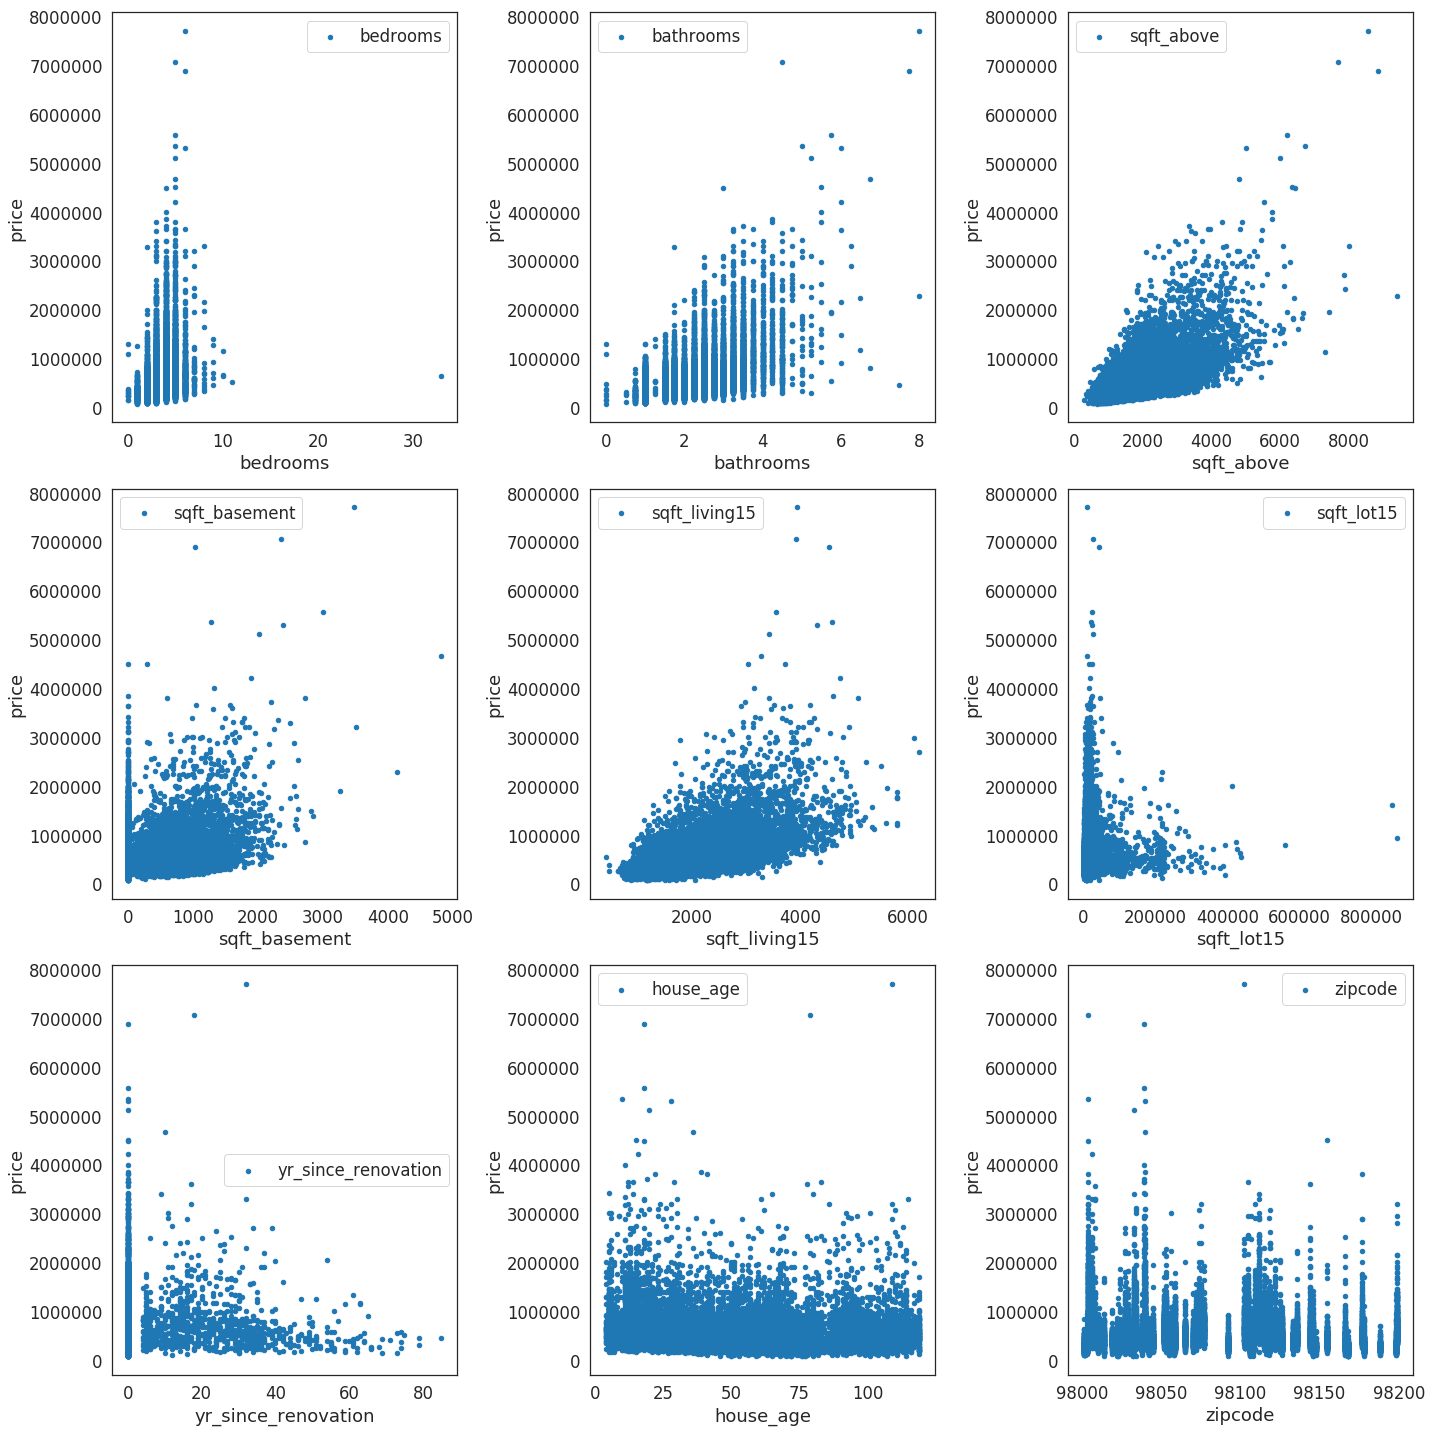

In [28]:
ncol = 3 # pick one dimension
nrow = math.floor((len(cols)+ ncol-1) / ncol) # make sure enough subplots
fig, axarr = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, 20)) # create the axes

for i in range(len(cols)): # go over a linear list of data
    ix = np.unravel_index(i, axarr.shape) # compute an appropriate index (1d or 2d)

    name = cols[i]
    dataset.plot(kind='scatter', x=name, y='price', ax=axarr[ix], label=name) 

plt.tight_layout()
plt.show();
# plt.savefig('pics/scatter_plot_1.png', dpi = 320)

**Notes:** 
    * Cross referencing on trulia, there are houses with a high sqft_living15 as well a price at $24,000,000
    * And as it turns out the number of bathrooms can be 8 or even 9, and it looks like that it might have some effect on the price
    * But 30+ bedrooms is an outlier, they as well looks like can have some effect on the price 
    * How does age (yr_built) and sqft_living coerlate?
    * It looks like that zipcodes are coerlated to price

## Investigating some of the outliers in numbers

In [29]:
dataset.sqft_lot15.value_counts(bins=10, sort=False)

(-219.55, 87705.9]      21216
(87705.9, 174760.8]       196
(174760.8, 261815.7]      166
(261815.7, 348870.6]       21
(348870.6, 435925.5]       10
(435925.5, 522980.4]        1
(522980.4, 610035.3]        1
(610035.3, 697090.2]        0
(697090.2, 784145.1]        0
(784145.1, 871200.0]        2
Name: sqft_lot15, dtype: int64

In [30]:
dataset.sqft_living15.value_counts(bins=10, sort=False)

(393.18800000000005, 980.1]     312
(980.1, 1561.2]                6440
(1561.2, 2142.3]               7587
(2142.3, 2723.4]               4200
(2723.4, 3304.5]               2004
(3304.5, 3885.6]                731
(3885.6, 4466.7]                235
(4466.7, 5047.8]                 84
(5047.8, 5628.9]                 12
(5628.9, 6210.0]                  8
Name: sqft_living15, dtype: int64

In [31]:
dataset.bedrooms.value_counts(bins=10, sort=False)

(-0.034, 3.3]    12796
(3.3, 6.6]        8755
(6.6, 9.9]          57
(9.9, 13.2]          4
(13.2, 16.5]         0
(16.5, 19.8]         0
(19.8, 23.1]         0
(23.1, 26.4]         0
(26.4, 29.7]         0
(29.7, 33.0]         1
Name: bedrooms, dtype: int64

In [32]:
dataset.price.value_counts(bins=10, sort=False)

(67374.999, 837500.0]     19022
(837500.0, 1600000.0]      2165
(1600000.0, 2362500.0]      298
(2362500.0, 3125000.0]       90
(3125000.0, 3887500.0]       26
(3887500.0, 4650000.0]        4
(4650000.0, 5412500.0]        4
(5412500.0, 6175000.0]        1
(6175000.0, 6937500.0]        1
(6937500.0, 7700000.0]        2
Name: price, dtype: int64

Regarding to [trulia](https://www.trulia.com/for_sale/53033_c/price;d_sort/) most of the so called outliers seen in the plot above seem legit (as of 11/02/2018).


---
### Investigating Continuos Variables in relationship to price

In [33]:
# 'house_age', 'sqft_basement', 'sqft_above', 'sqft_living15',  'sqft_lot15', 'yr_since_renovation'
#
continous_vars = ['sqft_living15',  'sqft_lot15', 'house_age', 'yr_since_renovation']

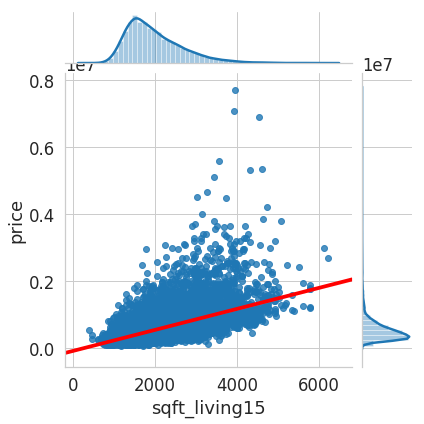

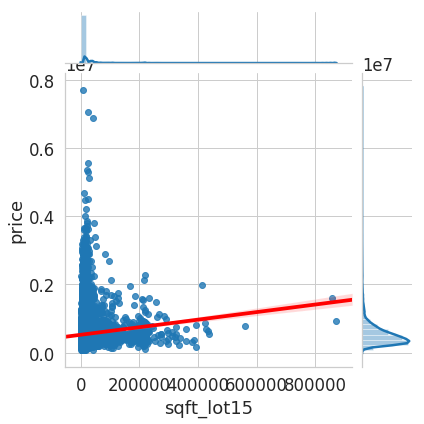

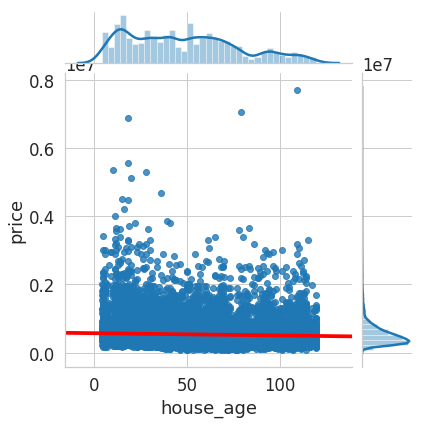

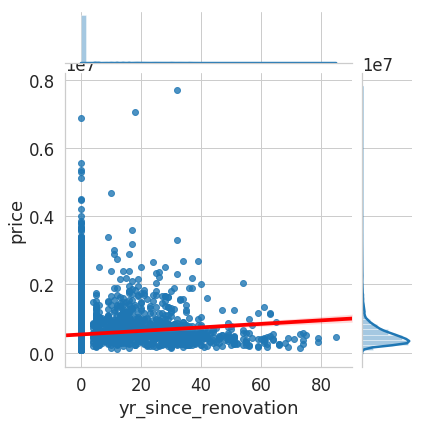

In [34]:
display_jointplot(dataset, continous_vars)

In [35]:
measure_strength(dataset, continous_vars, 'price')

Pearson correlation coefficient R and p-value 


price <=> sqft_living15		R = 0.5853789035795679 		 p = 0.0
price <=> sqft_lot15		R = 0.08244715251948598 		 p = 6.417559889335015e-34
price <=> house_age		R = -0.05401153149479272 		 p = 1.929872809374955e-15
price <=> yr_since_renovation		R = 0.07951738233958462 		 p = 1.159795661743707e-31


### Investigate Discrete Variables


In [36]:
discrete_vars = ['grade', 'condition', 'view', 'floors', 'bedrooms', 'bathrooms']

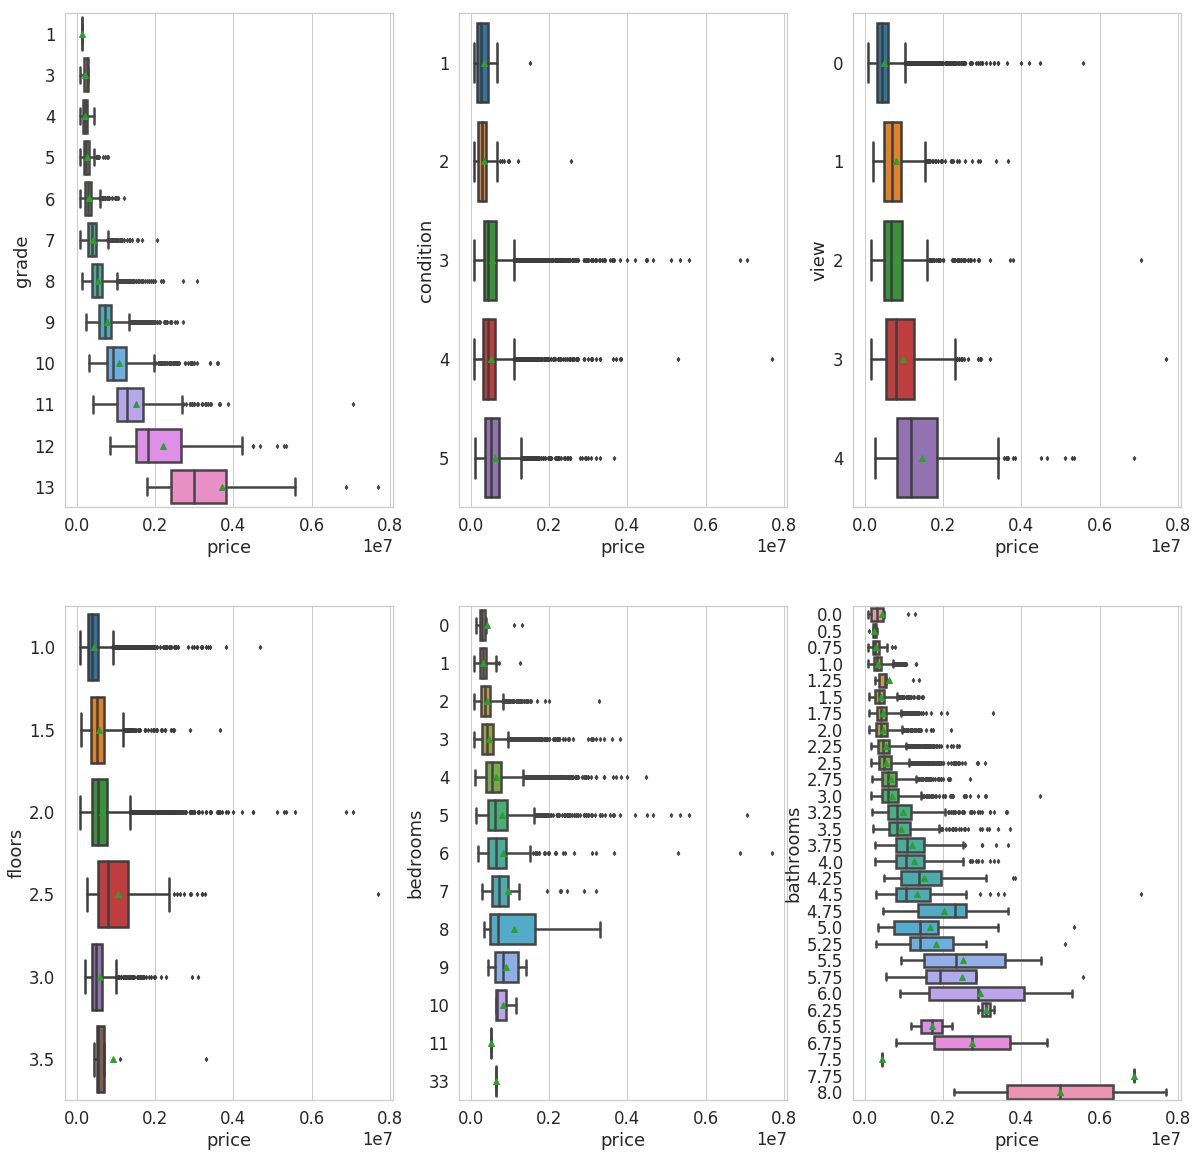

In [37]:
# Display box-and-whisker plot
#
display_plot(dataset, discrete_vars, 'price')

In [38]:
measure_strength(dataset, discrete_vars, 'price')

Pearson correlation coefficient R and p-value 


price <=> grade		R = 0.667434256020237 		 p = 0.0
price <=> condition		R = 0.036361789128997554 		 p = 8.935654062344094e-08
price <=> view		R = 0.3972934882945042 		 p = 0.0
price <=> floors		R = 0.2567938875507184 		 p = 1.6e-322
price <=> bedrooms		R = 0.3083495981456383 		 p = 0.0
price <=> bathrooms		R = 0.5251375054139618 		 p = 0.0


___

# Answer #1

### Visualize house prices and density by zipcode

Due to missing data we can't run the cells below.


In [39]:
# # Set zipcode type to string (folium)
# dataset['zipcode'] = dataset['zipcode'].astype('str')

# # get the mean value across all data points
# zipcode_data = dataset.groupby('zipcode').aggregate(np.mean)
# zipcode_data.reset_index(inplace = True)

In [40]:
# # count number of houses grouped by zipcode
# #
# dataset['count'] = 1
# t = dataset.groupby('zipcode').sum()
# t.reset_index(inplace = True)
# t = t[['zipcode', 'count']]
# zipcode_data = pd.merge(zipcode_data, t, on='zipcode')

# # drop count from org dataset
# dataset.drop(['count'], axis = 1, inplace = True)

In [41]:
# # Get geo data file path
# geo_data_file = os.path.join('data', '../input/king_county_wa_zipcode_area.geojson')

# # load GeoJSON
# with open(geo_data_file, 'r') as jsonFile:
#     geo_data = json.load(jsonFile)
    
# tmp = geo_data

# # remove ZIP codes not in geo data
# geozips = []
# for i in range(len(tmp['features'])):
#     if tmp['features'][i]['properties']['ZIPCODE'] in list(zipcode_data['zipcode'].unique()):
#         geozips.append(tmp['features'][i])

# # creating new JSON object
# new_json = dict.fromkeys(['type','features'])
# new_json['type'] = 'FeatureCollection'
# new_json['features'] = geozips

# # save uodated JSON object
# open("../input/cleaned_geodata.json", "w").write(json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')))

In [42]:
# map_feature_by_zipcode(zipcode_data, 'count')

In [43]:
# map_feature_by_zipcode(zipcode_data, 'price')

In [44]:
# Get the top 5 zipcode by price
#
# zipcode_data.nlargest(5, 'price')['zipcode']

###### Observation:
    * The most pricey zipcode 98039 seems to be also one of the less densly populated zipcode.
    * The housing density is focused around Seattle 

# Answer #2

Location, location, location. Waterfront properties are by far the most expensive once.

In [45]:
# Initialize Folium Map with Seattle latitude and longitude

# from folium.plugins import HeatMap

# max_val = dataset.price.max()

# lat = np.array(dataset.lat, dtype=pd.Series)
# lon = np.array(dataset.long, dtype=pd.Series)
# mag = np.array(dataset.price, dtype=pd.Series)

# d = np.dstack((lat, lon, mag))[0]
# heatmap_data = [i for i in d.tolist()]

# m = folium.Map(location=[47.35, -121.9], zoom_start=9, detect_retina=True, control_scale=False)
# HeatMap(heatmap_data, radius=1, blur=1).add_to(m)
# m

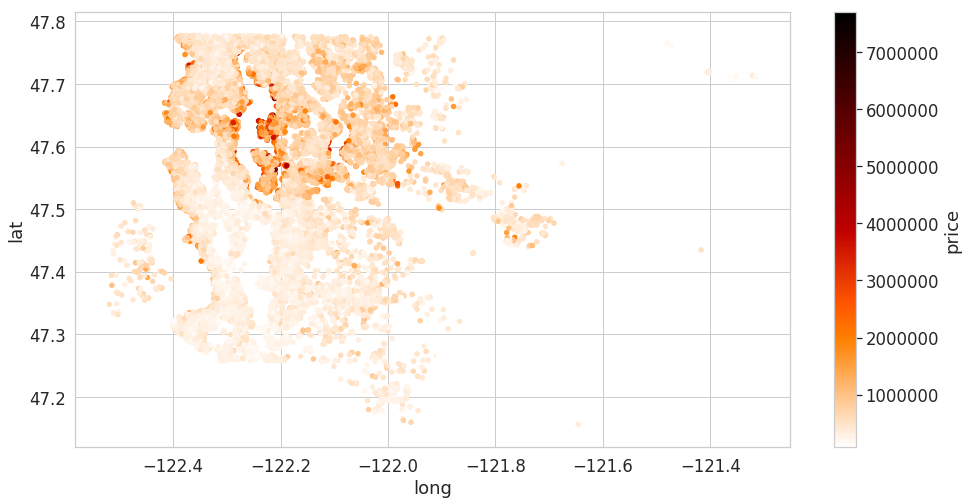

In [46]:
dataset.plot(kind="scatter", x="long", y="lat", figsize=(16, 8), c="price", 
             cmap="gist_heat_r", colorbar=True, sharex=False);
plt.show();

Simpler representation, but in this cae more effective. And brings the point across.

---
# Answering question  #3

### Relational plots
Lets visualize the relationship of price and sqft_living15 by grade and condition to hopefuly get a deeper inside

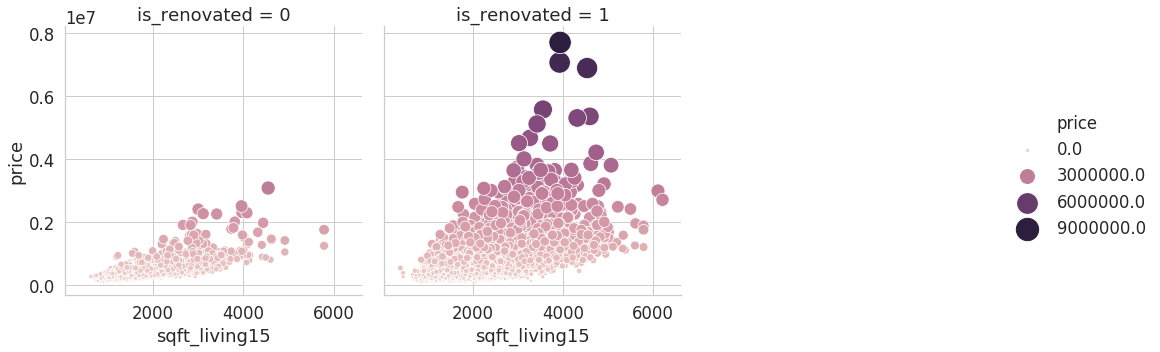

In [47]:
sns.relplot(x="sqft_living15", y="price", hue="price", col="is_renovated", 
            size="price", sizes=(5, 500), col_wrap=3, data=dataset);

It lloks like that renovation will affect the price

In [48]:
dataset.is_renovated.value_counts()

1    19112
0     2501
Name: is_renovated, dtype: int64

In [49]:
# get statistics for houses which are renovated
df_is_renovated = dataset[dataset['is_renovated'] == 1.0]

subset = ['price', 'bedrooms', 'floors', 'sqft_living15', 'sqft_lot15']
is_renovated_descriptives = round(df_is_renovated[subset].describe(), 2)
is_renovated_descriptives

,price,bedrooms,floors,sqft_living15,sqft_lot15
count,19112.00,19112.00,19112.00,19112.00,19112.00
mean,549016.23,3.38,1.47,1994.76,13135.51
std,378418.97,0.95,0.53,686.79,28010.89
min,75000.00,0.00,1.00,399.00,651.00
25%,325000.00,3.00,1.00,1493.50,5200.00
50%,455000.00,3.00,1.00,1850.00,7700.00
75%,653000.00,4.00,2.00,2370.00,10217.00
max,7700000.00,33.00,3.50,6210.00,871200.00


In [50]:
df_not_renovated = dataset[dataset['is_renovated'] == 0.0]

subset = ['price', 'bedrooms', 'floors', 'sqft_living15', 'sqft_lot15']
not_renovated_descriptives = round(df_not_renovated[subset].describe(), 2)
not_renovated_descriptives

,price,bedrooms,floors,sqft_living15,sqft_lot15
count,2501.00,2501.00,2501.00,2501.00,2501.00
mean,471861.97,3.28,1.65,1923.81,9963.52
std,255373.39,0.77,0.60,671.45,20930.44
min,86500.00,0.00,1.00,620.00,748.00
25%,308000.00,3.00,1.00,1430.00,4091.00
50%,416286.00,3.00,2.00,1770.00,6635.00
75%,565000.00,4.00,2.00,2310.00,9039.00
max,3075000.00,8.00,3.50,5790.00,360000.00


In [51]:
is_renovated_descriptives.price.median()

416709.485

In [52]:
not_renovated_descriptives.price.median()

362143.0

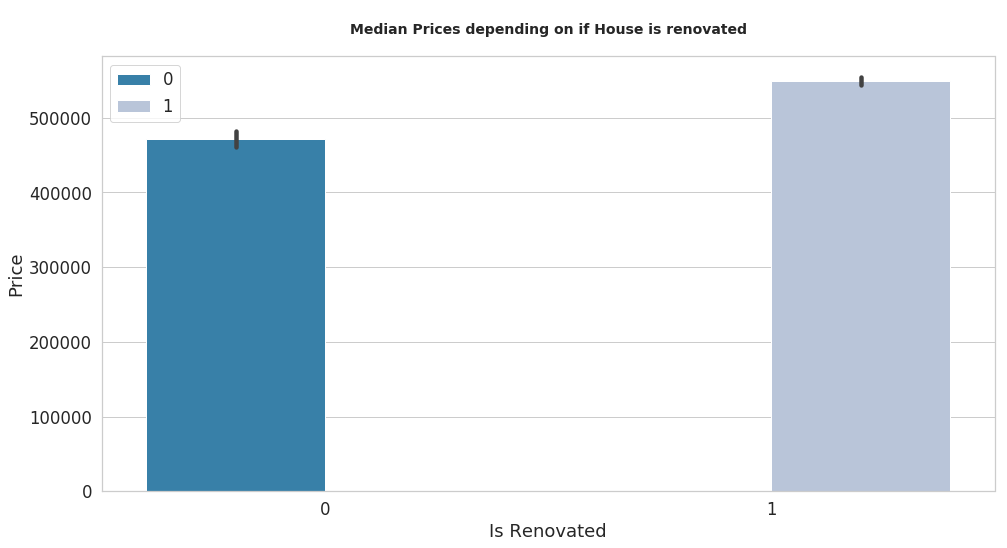

In [53]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x='is_renovated', y='price', hue='is_renovated', data=dataset, palette="PuBu_r")

# add title, legend and informative axis labels
ax.set_title('\nMedian Prices depending on if House is renovated\n', fontsize=14, fontweight='bold')
ax.set(ylabel='Price', xlabel='Is Renovated')
ax.legend(loc=2);

In [54]:
dataset['price'][dataset.is_renovated.max()] - dataset['price'][dataset.is_renovated.min()]

352500.0

Looks like that renovating can pay off by about $120,000, but there is no garantie for it.

---

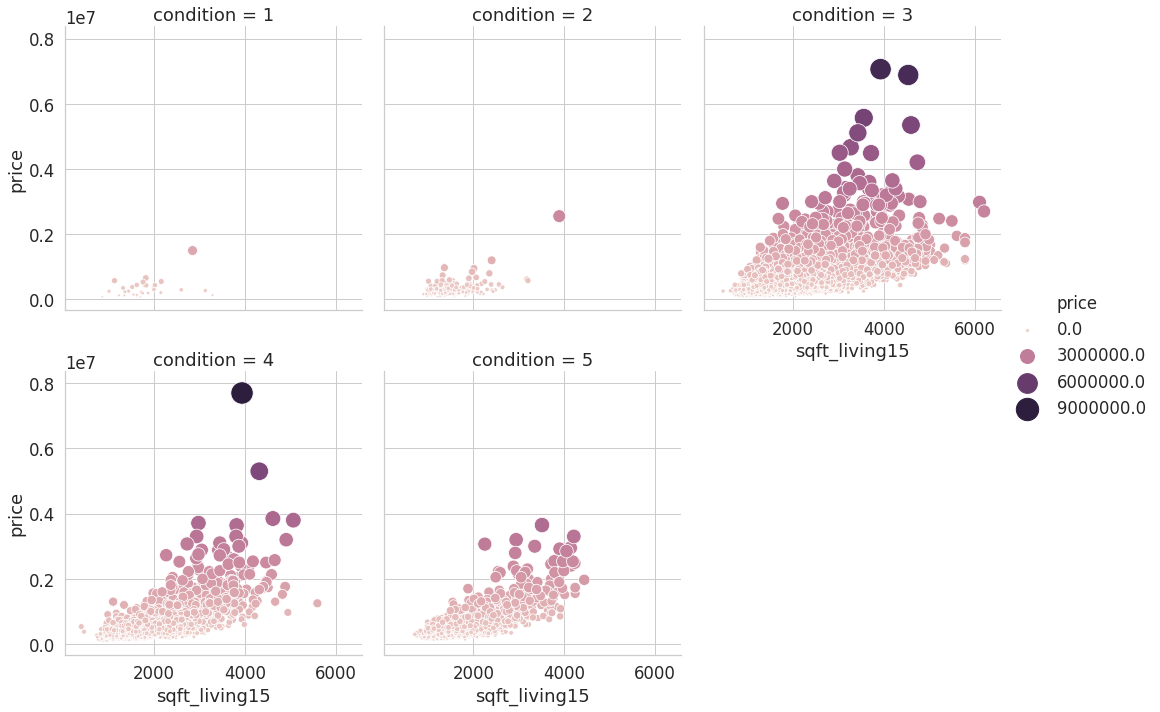

In [55]:
sns.relplot(x="sqft_living15", y="price", hue="price", col="condition",
            size="price", sizes=(5, 500), col_wrap=3, data=dataset);

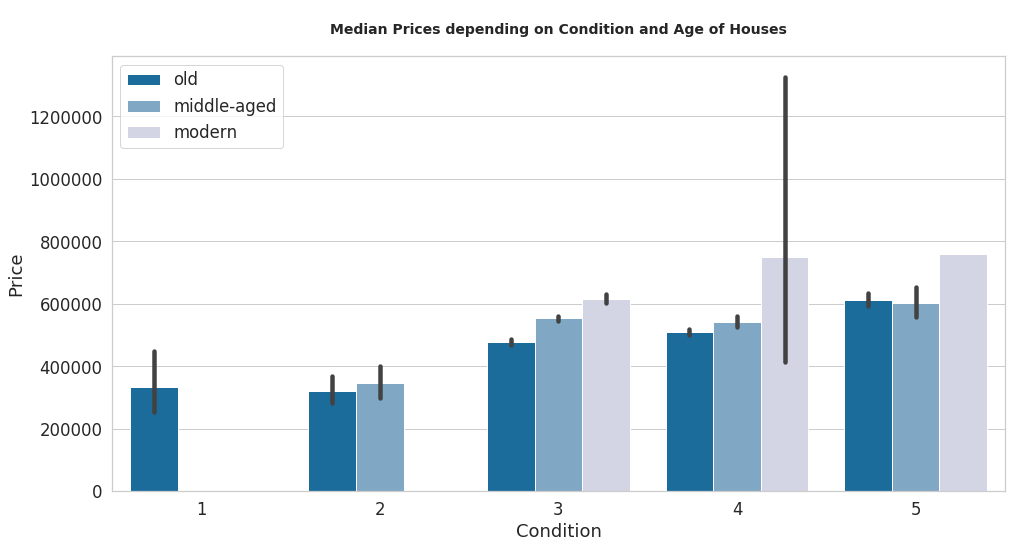

In [56]:
# plot this dataframe with seaborn
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x='condition', y='price', hue='yr_built_cat', data=dataset, palette="PuBu_r")

# add title, legend and informative axis labels
ax.set_title('\nMedian Prices depending on Condition and Age of Houses\n', fontsize=14, fontweight='bold')
ax.set(ylabel='Price', xlabel='Condition')
ax.legend(loc=2);

Houses which lay in the 3-5 catergory of condition (especially condition 4 for modern homes) seem to have higher price than older homes.

---

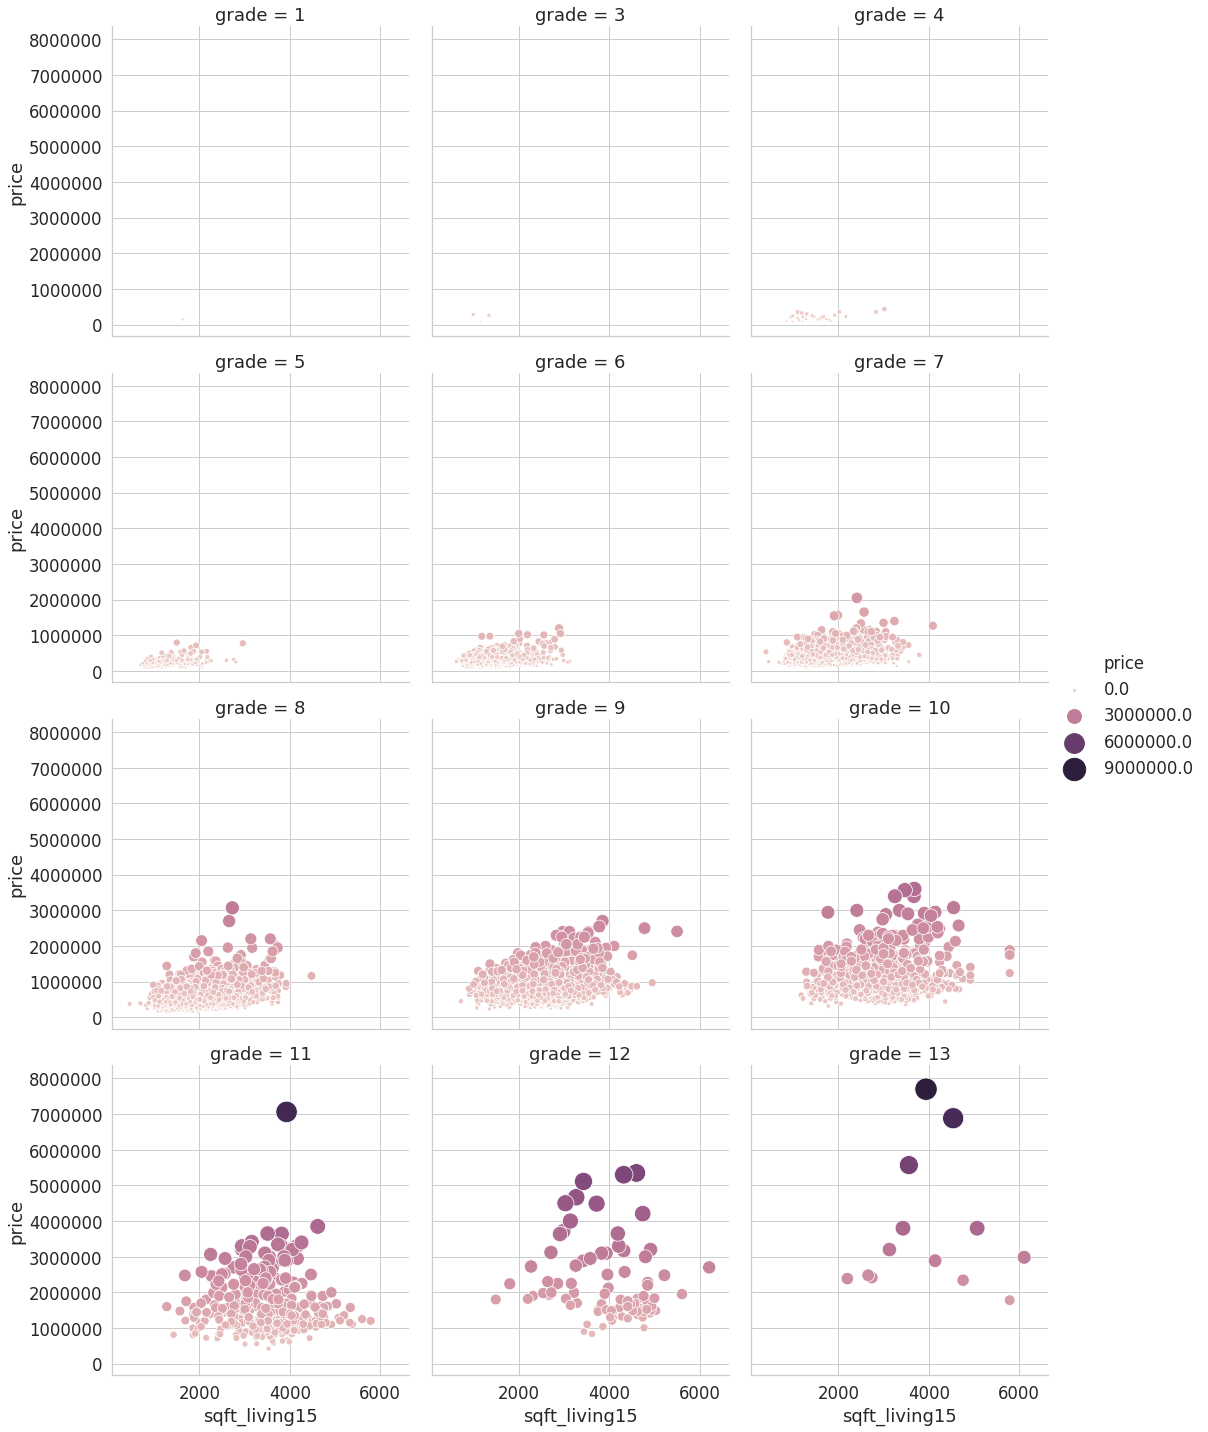

In [57]:
sns.relplot(x="sqft_living15", y="price", hue="price", col="grade", 
            size="price", sizes=(5, 500), col_wrap=3, data=dataset);

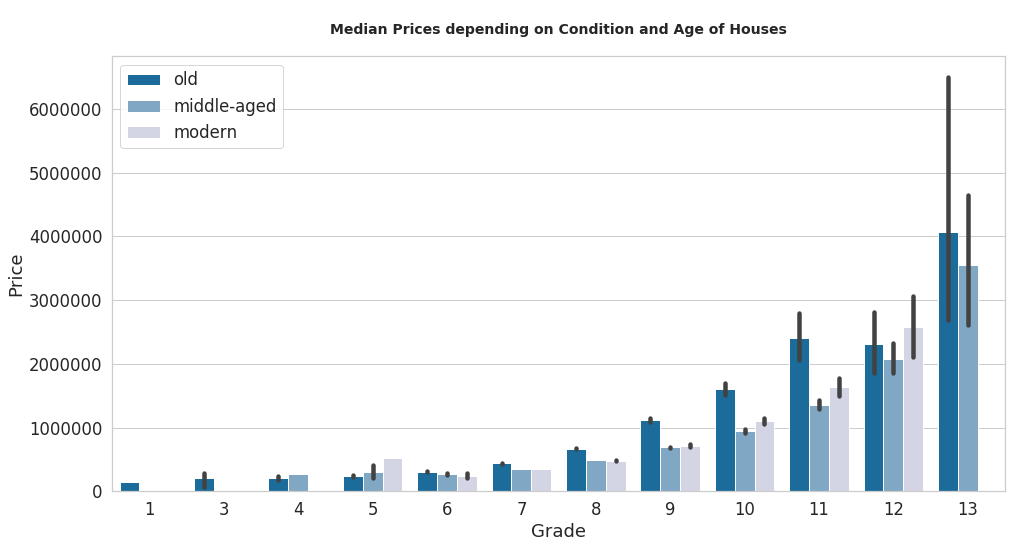

In [58]:
# plot this dataframe with seaborn
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x='grade', y='price', hue='yr_built_cat', data=dataset, palette="PuBu_r")

# add title, legend and informative axis labels
ax.set_title('\nMedian Prices depending on Condition and Age of Houses\n', fontsize=14, fontweight='bold')
ax.set(ylabel='Price', xlabel='Grade')
ax.legend(loc=2);

Grade reflects in the price more in older houses, especially houses older than 50 years.

**Conclusion:**
- Whether you renovate or not is a matter of the outcome you desire. But a simple home improvement seems to help with the selling price.
- The condition your house is in is important, especially you want to make sure you are in the category 3-5.
- The grade given for your house reflects in the price on older houses and therefore especially important.

___

### Categorize Data

We need to create dummy vars for our categorical variables. **One-hot encoding** shall do the trick. 

In [59]:
dataset['condition'] = dataset['condition'].astype('category', ordered = True)
dataset['waterfront'] = dataset['waterfront'].astype('category', ordered = True)
dataset['is_renovated'] = dataset['is_renovated'].astype('category', ordered = False)
dataset['view'] = dataset['view'].astype('category', ordered = False)

# Create category 'has_basement'
dataset['has_basement'] = dataset.sqft_basement.apply(lambda x: 1 if x > 0 else 0)
dataset['has_basement'] = dataset.has_basement.astype('category', ordered = False)

In [60]:
# Set dummies (we may want to add zipcode as well)
cat_columns = ['floors', 'view', 'condition', 'waterfront', 'is_renovated', 'has_basement']

for col in cat_columns:
    dummies = pd.get_dummies(dataset[col])
    dummies = dummies.add_prefix("{}_".format(col))
    
    dataset.drop(col, axis=1, inplace=True)
    dataset = dataset.join(dummies)

In [61]:
# replace the '.' in the column name
for col in dataset.columns:
    if col.find('.') != -1: 
        dataset.rename(columns={col: col.replace('.', '_')}, inplace=True)

### Dropping features

Finally we shall drop eature we are still carrying around but for sure are not needed.

In [62]:
# dropping id and date
dataset.drop(['id', 'date', 'lat', 'long'], axis = 1, inplace = True)

In [63]:
dataset.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,yr_since_renovation,yr_renov_bins,house_age,yr_built_cat,floors_1_0,floors_1_5,floors_2_0,floors_2_5,floors_3_0,floors_3_5,view_0,view_1,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5,waterfront_0,waterfront_1,is_renovated_0,is_renovated_1,has_basement_0,has_basement_1
0,437500.0,3,2.25,1970,35100,9,1970,0,1977,98027,2340,35100,0,never,42,middle-aged,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0
1,790000.0,3,2.50,2600,4750,9,1700,900,1951,98117,2380,4750,0,never,68,old,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1
2,675000.0,5,2.50,2820,67518,8,2820,0,1979,98029,2820,48351,0,never,40,middle-aged,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
3,555000.0,4,2.50,3310,6500,8,3310,0,2012,98065,2380,5000,0,never,7,modern,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0
4,440000.0,4,2.25,2160,8119,8,1080,1080,1966,98006,1850,9000,0,never,53,old,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1


In [64]:
dataset.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,yr_since_renovation,house_age,floors_1_0,floors_1_5,floors_2_0,floors_2_5,floors_3_0,floors_3_5,view_0,view_1,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5,waterfront_0,waterfront_1,is_renovated_0,is_renovated_1,has_basement_0,has_basement_1
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,7.656873,1788.390691,291.509045,1971.005136,98077.939805,1986.552492,12768.455652,0.979966,47.994864,0.494147,0.088373,0.381298,0.007449,0.028363,0.000370,0.901726,0.015361,0.044557,0.023597,0.014760,0.001388,0.007958,0.649193,0.262759,0.078703,0.992458,0.007542,0.115717,0.884283,0.607320,0.392680
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,1.175459,828.090978,442.575043,29.373411,53.505026,685.391304,27304.179631,5.649874,29.373411,0.499977,0.283843,0.485717,0.085989,0.166010,0.019236,0.297692,0.122987,0.206333,0.151793,0.120592,0.037232,0.088855,0.477234,0.440143,0.269280,0.086517,0.086517,0.319893,0.319893,0.488358,0.488358
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,290.000000,0.000000,1900.000000,98001.000000,399.000000,651.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,7.000000,1190.000000,0.000000,1951.000000,98033.000000,1490.000000,5100.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,7.000000,1560.000000,0.000000,1975.000000,98065.000000,1840.000000,7620.000000,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,8.000000,2210.000000,560.000000,1997.000000,98118.000000,2360.000000,10083.000000,0.000000,68.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,13.000000,9410.000000,4820.000000,2015.000000,98199.000000,6210.000000,871200.000000,85.000000,119.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Normalize dataset

In [65]:
# Using MinMax
#
minmax_df = dataset[['house_age', 'yr_since_renovation', 'zipcode']]

scaler = preprocessing.MinMaxScaler()
minmax_scaled_df = scaler.fit_transform(minmax_df)
minmax_scaled_df = pd.DataFrame(minmax_scaled_df, columns=['house_age', 'yr_since_renovation', 'zipcode'])

In [66]:
# Using Robust for price and sqft
#
robust_df = dataset[['price', 'sqft_above', 'sqft_living15', 'sqft_lot15']]

scaler = preprocessing.RobustScaler()
robust_scaled_df = scaler.fit_transform(robust_df)
robust_scaled_df = pd.DataFrame(robust_scaled_df, columns=['price', 'sqft_above', 'sqft_living15', 'sqft_lot15'])

## Concat normalized data and selected feature into new dataframe

In [67]:
dataset_ols = pd.concat([dataset[['grade', 'bedrooms', 'bathrooms', 'condition_3', 'condition_4', 
                                  'condition_5']], minmax_scaled_df, robust_scaled_df], axis=1)

In [68]:
dataset_ols.head()

,grade,bedrooms,bathrooms,condition_3,condition_4,condition_5,house_age,yr_since_renovation,zipcode,price,sqft_above,sqft_living15,sqft_lot15
0,9,3,2.25,0,1,0,0.330435,0.0,0.131313,-0.038694,0.401961,0.574713,5.514750
1,9,3,2.50,0,1,0,0.556522,0.0,0.585859,1.052469,0.137255,0.620690,-0.575958
2,8,5,2.50,1,0,0,0.313043,0.0,0.141414,0.696487,1.235294,1.126437,8.173992
3,8,4,2.50,1,0,0,0.026087,0.0,0.323232,0.325027,1.715686,0.620690,-0.525788
4,8,4,2.25,1,0,0,0.426087,0.0,0.025253,-0.030955,-0.470588,0.011494,0.276942


___

## Regression Model

In [69]:
ols_results = []
if len(ols_results) != 1:
    ols_results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)']]

In [70]:
features = ['grade', 'bedrooms', 'bathrooms', 'house_age', 'yr_since_renovation', 'sqft_above',
            'sqft_living15', 'sqft_lot15', 'zipcode', 'condition_3', 'condition_4', 'condition_5']

In [71]:
def run_ols_regression(store_results, data, target, feature, show_plots=False):
    """
    Run ols model, prints model summary, displays plot_regress_exog and qqplot
    
    :param data: dataset
    :param target: target feature name
    :param feature: feature name
    :return:
    """
    
    formula = target + '~' + feature
    model = ols(formula=formula, data=data).fit()

    df = pd.DataFrame({feature: [data[feature].min(), data[feature].max()]})
    pred = model.predict(df)

    if show_plots:
        print('Regression Analysis and Diagnostics for formula: ', formula)
        print('\n')

        fig = plt.figure(figsize=(16, 8))
        fig = sm.graphics.plot_regress_exog(model, feature, fig=fig)
        plt.show();

        residuals = model.resid
        fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
        fig.show();
    
    # append all information to results
    store_results.append([feature, model.rsquared, model.params[0], model.params[0],
                        model.pvalues[1], sms.jarque_bera(model.resid)[0]])


### Check out each feature by itself

In [72]:
for feature in features:
    run_ols_regression(ols_results, dataset_ols, 'price', feature)

In [73]:
pd.DataFrame(ols_results)

,0,1,2,3,4,5
0,ind_var,r_squared,intercept,slope,p-value,normality (JB)
1,grade,0.445468,-4.66196,-4.66196,0,2.05309e+06
2,bedrooms,0.0950795,-0.991171,-0.991171,0,1.19904e+06
3,bathrooms,0.275769,-1.35983,-1.35983,0,887102
4,house_age,0.00291725,0.370802,0.370802,1.92987e-15,1.1462e+06
5,yr_since_renovation,0.00632301,0.263193,0.263193,1.1598e-31,1.10006e+06
6,sqft_above,0.366712,0.0890616,0.0890616,0,732831
7,sqft_living15,0.342668,0.136622,0.136622,0,1.92001e+06
8,sqft_lot15,0.00679753,0.2612,0.2612,6.41756e-34,1.14583e+06
9,zipcode,0.00283054,0.365811,0.365811,5.01105e-15,1.12696e+06


### Go through the selection process

In [74]:
y = dataset_ols['price']
X = dataset_ols.drop(['price'], axis=1)

In [75]:
result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

Add  bathrooms                      with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  grade                          with p-value 0.0
Add  house_age                      with p-value 0.0
Add  sqft_above                     with p-value 4.18227e-99
Add  bedrooms                       with p-value 2.65191e-32
Add  condition_5                    with p-value 7.76139e-18
Add  zipcode                        with p-value 2.71194e-09
Add  condition_4                    with p-value 2.93637e-09
Add  sqft_lot15                     with p-value 3.02216e-08
resulting features:
['bathrooms', 'sqft_living15', 'grade', 'house_age', 'sqft_above', 'bedrooms', 'condition_5', 'zipcode', 'condition_4', 'sqft_lot15']


### Do your regression model

In [76]:
pred = '+'.join(features)
formula = 'price~' + pred

In [77]:
model = ols(formula=formula, data=dataset_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     2610.
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:50:13   Log-Likelihood:                -23748.
No. Observations:               21613   AIC:                         4.752e+04
Df Residuals:                   21600   BIC:                         4.763e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.3676      0.076    -57.561      0.000      -4.516      -4.219
grade                   0.4505      0.007     61.246      0.000       0.436       0.465
bedrooms               -0.0807      0.007    -12.379      0.000      -0.093      -0.068
bathrooms               0.3393      0.010     32.581      0.000       0.319       0.360
house_age               1.5787      0.027     58.137      0.000       1.526       1.632
yr_since_renovation     0.1701      0.077      2.196      0.028       0.018       0.322
sqft_above              0.2789      0.011     24.762      0.000       0.257       0.301
sqft_living15           0.1976      0.010     19.583      0.000       0.178       0.217
sqft_lot15             -0.0052      0.001     -5.583      0.000      -0.007      -0.003
zipcode                 0.1330      0.021      6.482      0.000       0.093       0.173
condition_3            -0.0337      0.052     -0.647      0.518      -0.136       0.068
condition_4             0.0447      0.052      0.854      0.393      -0.058       0.147
condition_5             0.1719      0.054      3.160      0.002       0.065       0.279
==============================================================================
Omnibus:                    19354.659   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1953956.933
Skew:                           3.898   Prob(JB):                         0.00
Kurtosis:                      48.924   Cond. No.                         192.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We shall drop 'yr_since_renovation', 'sqft_above', 'bedrooms', 'condition_3', 'condition_4' 
from the feature list

## Regression Model Validation

In [78]:
y = dataset_ols['price']
X = dataset_ols.drop(['price', 'yr_since_renovation', 'sqft_above', 'condition_3', 'condition_4'], axis=1)

In [79]:
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     3725.
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:50:14   Log-Likelihood:                -24064.
No. Observations:               21613   AIC:                         4.815e+04
Df Residuals:                   21604   BIC:                         4.822e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.0481      0.054    -93.817      0.000      -5.154      -4.943
grade             0.5148      0.007     74.010      0.000       0.501       0.528
bedrooms         -0.0477      0.006     -7.385      0.000      -0.060      -0.035
bathrooms         0.3975      0.010     38.813      0.000       0.377       0.418
condition_5       0.1460      0.019      7.550      0.000       0.108       0.184
house_age         1.6108      0.025     63.620      0.000       1.561       1.660
zipcode           0.0824      0.020      4.026      0.000       0.042       0.123
sqft_living15     0.2816      0.010     29.247      0.000       0.263       0.300
sqft_lot15       -0.0021      0.001     -2.208      0.027      -0.004      -0.000
==============================================================================
Omnibus:                    20435.225   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2531980.058
Skew:                           4.205   Prob(JB):                         0.00
Kurtosis:                      55.354   Cond. No.                         98.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---
Iterating over the feature seem not to make any improvements on our R-squared value.

##### Furthermore:
- The regression output shows that most variables are statistically significant with **p-values** less than 0.05. 
- With regards to the **coefficients**, most variables are positively correlated with the price, only (lower) grades, a renovation status years back and the building year are negatively correlated.

#### Final thoughts:
The grade of a house has more impact on the price if a house is older than 15 years and even more so if older than 50 years. That said the grade reflects to some extend the size of a house (cabin vs mansoin) but mostly the condition the house is in (poor, average all the way to luxury). The condition of a house has some effect on the price if it is in the range 3 - 5 on all houses no matter the age. One can make the argument that the conidition of a house is coralated wheather or not it is renovated. Renovation has a effect on the price of the house of a median average of $120,000. It is not known what kind of investment one has to make in order to gain such return.


## Sanity Check using sklearn

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

17290 4323 17290 4323


In [81]:
# Fitting the model to the training data
linreg = LinearRegression().fit(X_train, y_train)

# Calc preditors on the train and test set
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [82]:
# Calc residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [83]:
# Calc MSE (Mean Squared Error)
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.5526151866881771
Test Mean Squarred Error: 0.5050037889601044


### Residual Histogram

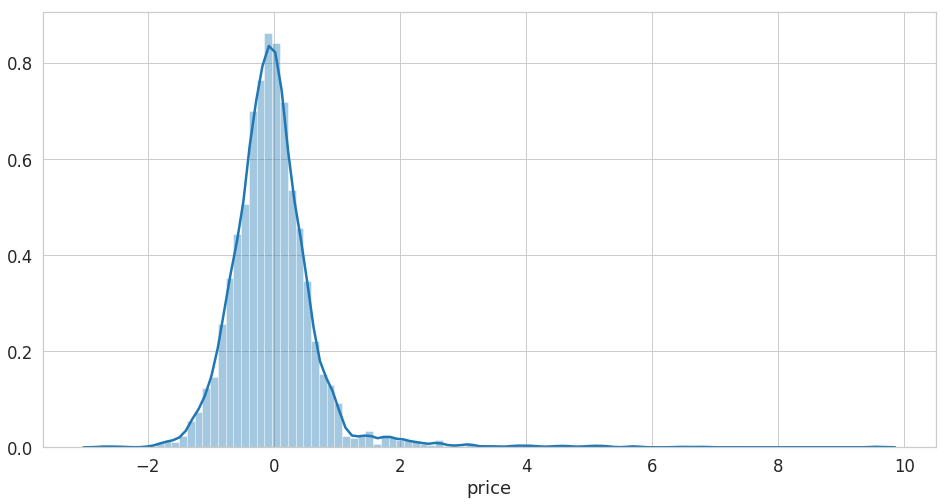

In [84]:
fig = plt.figure(figsize=(16, 8))
sns.distplot(y_test - y_hat_test, bins=100);
# sns.distplot(test_residuals, bins=50)

## Cross Validation

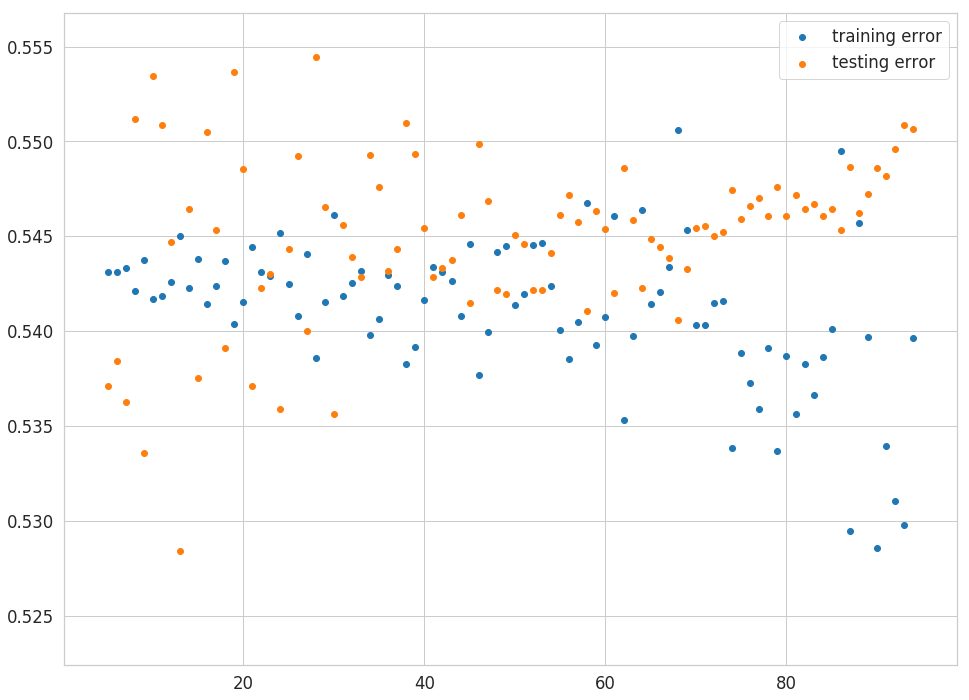

In [85]:
train_error = []
test_error = []

for t in range(5, 95):
    train_temp = []
    test_temp = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t/100)
        linreg.fit(X_train, y_train)

        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)

        train_temp.append(mean_squared_error(y_train, y_hat_train))
        test_temp.append(mean_squared_error(y_test, y_hat_test))
    
    # save average train/test errors
    train_error.append(np.mean(train_temp))
    test_error.append(np.mean(test_temp))

fig = plt.figure(figsize=(16, 12))
plt.scatter(range(5, 95), train_error, label='training error')
plt.scatter(range(5, 95), test_error, label='testing error')

plt.legend()
plt.show()

In [86]:
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error"))

In [87]:
print(cv_5_results, cv_10_results, cv_20_results)

-0.5450434307390778 -0.5445529773064102 -0.5440105006300906


### Regression Evaluation

In [88]:
print('Measure of the quality of an estimator - values closer to zero are better\n\n')
print('MAE: ', metrics.mean_absolute_error(y_test, y_hat_test))
print('MSE: ', metrics.mean_squared_error(y_test, y_hat_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))

Measure of the quality of an estimator - values closer to zero are better


MAE:  0.485064120292039
MSE:  0.5472057715619485
RMSE: 0.7397335814750797


---
## Answers
1. Zip Code (neighborhood) can be an indicator for house prices 
    (see the top 5 zip codes 98039, 98004, 98040, 98112, 98102).
2. Housing density in condery is less an indicator for the house price.
3. Regards grade and condition of the house I believe that with the data given we have too little informations and therefore is inconclusive.